In [1]:
import torch
import torch.nn as nn

import numpy as np
import random
from model import QNetwork, get_network_input
from Game import GameEnvironment
from collections import deque
from replay_buffer import ReplayMemory
import time

model = QNetwork(input_dim=10, hidden_dim=20, output_dim=5)
epsilon = 0.1
gridsize = 15 
GAMMA = 0.9

board = GameEnvironment(gridsize, nothing=0, dead=-1, apple=1)
memory = ReplayMemory(1000)  
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)


In [2]:
def run_episode(num_games):
    run = True
    move=0
    games_played = 0
    total_reward = 0    
    episode_games = 0
    len_array = []
    
    while run:
        state = get_network_input(board.snake, board.apple)
        action_0 = model(state)
        rand = np.random.uniform(0,1)
        if rand > epsilon:
            action = torch.argmax(action_0)
        else:
            action = np.random.randint(0,5)

        ## update_boardstate the same snake till    
        reward, done, len_of_snake = board.update_boardstate(action)
        next_state = get_network_input(board.snake, board.apple)
        
        memory.push(state, action, reward, next_state, done)
        
        total_reward += reward
        
        episode_games += 1
        
        if board.game_over == True:
            games_played += 1
            len_array.append(len_of_snake)
            board.resetgame()
            
            if num_games == games_played:
                run = False
                
    avg_len_of_snake = np.mean(len_array)
    max_len_of_snake = np.max(len_array)
    return total_reward, avg_len_of_snake, max_len_of_snake

In [3]:
MSE = nn.MSELoss()
def learn(num_updates, batch_size):
    
    total_loss = 0
    
    for i in range(num_updates):

        optimizer.zero_grad()
        sample = memory.sample(batch_size)
            
        states, actions, rewards, next_states, dones = sample
        states = torch.cat([x.unsqueeze(0) for x in states], dim=0) 
        actions = torch.LongTensor(actions) 
        rewards = torch.FloatTensor(rewards) 
        next_states = torch.cat([x.unsqueeze(0) for x in next_states]) 
        dones = torch.FloatTensor(dones) 
        
        q_local = model.forward(states)
        next_q_value = model.forward(next_states)

        Q_expected  = q_local.gather(1, actions.unsqueeze(0).transpose(0,1)).transpose(0,1).squeeze(0)  
        
        Q_targets_next  = torch.max(next_q_value, 1)[0]*(torch.ones(dones.size()) - dones)
        
        Q_targets  = rewards + GAMMA * Q_targets_next 
        
        loss = MSE(Q_expected, Q_targets)
        
        total_loss += loss
        loss.backward()
        optimizer.step()
        
    return total_loss

In [4]:
num_episodes = 60000 
num_updates = 500 
print_every = 10
games_in_episode = 30
batch_size = 20


def train():
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    avg_len_array = []
    avg_max_len_array = []
    
    time_start = time.time()
    
    
    for i_episode in range(num_episodes+1):
        
        ## print('i_episode: ', i_episode)
        
        score, avg_len, max_len = run_episode(games_in_episode)
        
        scores_deque.append(score)
        scores_array.append(score)
        avg_len_array.append(avg_len)
        avg_max_len_array.append(max_len)
        
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        total_loss = learn(num_updates, batch_size)
        
        dt = (int)(time.time() - time_start)
        
        if i_episode % print_every == 0 and i_episode > 0:
            print('Ep.: {:6}, Loss: {:.3f}, Avg.Score: {:.2f}, Avg.LenOfSnake: {:.2f}, Max.LenOfSnake:  {:.2f} Time: {:02}:{:02}:{:02} '.\
                  format(i_episode, total_loss, score, avg_len, max_len, dt//3600, dt%3600//60, dt%60))
            
        memory.truncate()
        
        if i_episode % 250 == 0 and i_episode > 0:   
            torch.save(model.state_dict(), './dir_chk_len/Snake_{}'.format(i_episode))
            
    return scores_array, avg_scores_array, avg_len_array, avg_max_len_array    

scores, avg_scores, avg_len_of_snake, max_len_of_snake = train()

Ep.:     10, Loss: 8.479, Avg.Score: -30.00, Avg.LenOfSnake: 5.00, Max.LenOfSnake:  5.00 Time: 00:00:17 
Ep.:     20, Loss: 6.884, Avg.Score: -29.00, Avg.LenOfSnake: 5.03, Max.LenOfSnake:  6.00 Time: 00:00:33 
Ep.:     30, Loss: 5.100, Avg.Score: -27.00, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:00:47 
Ep.:     40, Loss: 5.464, Avg.Score: -29.00, Avg.LenOfSnake: 5.03, Max.LenOfSnake:  6.00 Time: 00:01:02 
Ep.:     50, Loss: 6.070, Avg.Score: -26.00, Avg.LenOfSnake: 5.13, Max.LenOfSnake:  6.00 Time: 00:01:17 
Ep.:     60, Loss: 5.344, Avg.Score: -26.00, Avg.LenOfSnake: 5.13, Max.LenOfSnake:  7.00 Time: 00:01:35 
Ep.:     70, Loss: 5.554, Avg.Score: -28.00, Avg.LenOfSnake: 5.07, Max.LenOfSnake:  6.00 Time: 00:01:52 
Ep.:     80, Loss: 5.250, Avg.Score: -29.00, Avg.LenOfSnake: 5.03, Max.LenOfSnake:  6.00 Time: 00:02:11 
Ep.:     90, Loss: 5.612, Avg.Score: -27.00, Avg.LenOfSnake: 5.10, Max.LenOfSnake:  6.00 Time: 00:02:31 
Ep.:    100, Loss: 7.287, Avg.Score: -22.00, Avg.LenOfS

Ep.:   1560, Loss: 12.332, Avg.Score: 132.00, Avg.LenOfSnake: 10.40, Max.LenOfSnake:  19.00 Time: 00:59:58 
Ep.:   1570, Loss: 11.576, Avg.Score: 107.00, Avg.LenOfSnake: 9.57, Max.LenOfSnake:  22.00 Time: 01:00:26 
Ep.:   1580, Loss: 14.535, Avg.Score: 155.00, Avg.LenOfSnake: 11.17, Max.LenOfSnake:  18.00 Time: 01:00:53 
Ep.:   1590, Loss: 14.901, Avg.Score: 109.00, Avg.LenOfSnake: 9.63, Max.LenOfSnake:  19.00 Time: 01:01:20 
Ep.:   1600, Loss: 13.543, Avg.Score: 106.00, Avg.LenOfSnake: 9.53, Max.LenOfSnake:  22.00 Time: 01:01:46 
Ep.:   1610, Loss: 12.156, Avg.Score: 163.00, Avg.LenOfSnake: 11.43, Max.LenOfSnake:  18.00 Time: 01:02:14 
Ep.:   1620, Loss: 15.063, Avg.Score: 167.00, Avg.LenOfSnake: 11.57, Max.LenOfSnake:  22.00 Time: 01:02:41 
Ep.:   1630, Loss: 13.607, Avg.Score: 132.00, Avg.LenOfSnake: 10.40, Max.LenOfSnake:  20.00 Time: 01:03:09 
Ep.:   1640, Loss: 12.614, Avg.Score: 137.00, Avg.LenOfSnake: 10.57, Max.LenOfSnake:  17.00 Time: 01:03:39 
Ep.:   1650, Loss: 12.532, Avg.

Ep.:   3060, Loss: 9.330, Avg.Score: 228.00, Avg.LenOfSnake: 13.60, Max.LenOfSnake:  28.00 Time: 02:25:15 
Ep.:   3070, Loss: 10.427, Avg.Score: 206.00, Avg.LenOfSnake: 12.87, Max.LenOfSnake:  37.00 Time: 02:25:52 
Ep.:   3080, Loss: 9.859, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  27.00 Time: 02:26:30 
Ep.:   3090, Loss: 9.202, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  25.00 Time: 02:27:08 
Ep.:   3100, Loss: 10.138, Avg.Score: 204.00, Avg.LenOfSnake: 12.80, Max.LenOfSnake:  25.00 Time: 02:27:47 
Ep.:   3110, Loss: 11.003, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  29.00 Time: 02:28:25 
Ep.:   3120, Loss: 10.029, Avg.Score: 243.00, Avg.LenOfSnake: 14.10, Max.LenOfSnake:  28.00 Time: 02:29:04 
Ep.:   3130, Loss: 10.533, Avg.Score: 273.00, Avg.LenOfSnake: 15.10, Max.LenOfSnake:  29.00 Time: 02:29:44 
Ep.:   3140, Loss: 11.135, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  28.00 Time: 02:30:23 
Ep.:   3150, Loss: 10.437, Avg.

Ep.:   4580, Loss: 7.459, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  24.00 Time: 04:05:57 
Ep.:   4590, Loss: 8.220, Avg.Score: 265.00, Avg.LenOfSnake: 14.83, Max.LenOfSnake:  28.00 Time: 04:06:31 
Ep.:   4600, Loss: 9.407, Avg.Score: 168.00, Avg.LenOfSnake: 11.60, Max.LenOfSnake:  23.00 Time: 04:07:06 
Ep.:   4610, Loss: 8.894, Avg.Score: 281.00, Avg.LenOfSnake: 15.37, Max.LenOfSnake:  30.00 Time: 04:07:44 
Ep.:   4620, Loss: 7.748, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  25.00 Time: 04:08:20 
Ep.:   4630, Loss: 8.344, Avg.Score: 190.00, Avg.LenOfSnake: 12.33, Max.LenOfSnake:  23.00 Time: 04:08:56 
Ep.:   4640, Loss: 7.908, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  28.00 Time: 04:09:32 
Ep.:   4650, Loss: 8.206, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  32.00 Time: 04:10:07 
Ep.:   4660, Loss: 9.507, Avg.Score: 295.00, Avg.LenOfSnake: 15.83, Max.LenOfSnake:  35.00 Time: 04:10:45 
Ep.:   4670, Loss: 8.398, Avg.Score: 

Ep.:   6100, Loss: 10.143, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  27.00 Time: 05:42:44 
Ep.:   6110, Loss: 9.553, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  30.00 Time: 05:43:25 
Ep.:   6120, Loss: 8.661, Avg.Score: 263.00, Avg.LenOfSnake: 14.77, Max.LenOfSnake:  29.00 Time: 05:44:05 
Ep.:   6130, Loss: 8.288, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  27.00 Time: 05:44:45 
Ep.:   6140, Loss: 8.832, Avg.Score: 196.00, Avg.LenOfSnake: 12.53, Max.LenOfSnake:  27.00 Time: 05:45:22 
Ep.:   6150, Loss: 9.115, Avg.Score: 222.00, Avg.LenOfSnake: 13.40, Max.LenOfSnake:  26.00 Time: 05:46:02 
Ep.:   6160, Loss: 9.393, Avg.Score: 180.00, Avg.LenOfSnake: 12.00, Max.LenOfSnake:  29.00 Time: 05:46:45 
Ep.:   6170, Loss: 8.991, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  32.00 Time: 05:47:25 
Ep.:   6180, Loss: 7.686, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  28.00 Time: 05:48:08 
Ep.:   6190, Loss: 9.382, Avg.Score:

Ep.:   7620, Loss: 7.782, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  25.00 Time: 07:23:18 
Ep.:   7630, Loss: 8.506, Avg.Score: 285.00, Avg.LenOfSnake: 15.50, Max.LenOfSnake:  28.00 Time: 07:23:54 
Ep.:   7640, Loss: 8.128, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  27.00 Time: 07:24:31 
Ep.:   7650, Loss: 8.684, Avg.Score: 222.00, Avg.LenOfSnake: 13.40, Max.LenOfSnake:  28.00 Time: 07:25:09 
Ep.:   7660, Loss: 12.915, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  37.00 Time: 07:25:47 
Ep.:   7670, Loss: 7.728, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  27.00 Time: 07:26:22 
Ep.:   7680, Loss: 8.663, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  26.00 Time: 07:27:03 
Ep.:   7690, Loss: 8.194, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  23.00 Time: 07:27:40 
Ep.:   7700, Loss: 8.327, Avg.Score: 199.00, Avg.LenOfSnake: 12.63, Max.LenOfSnake:  30.00 Time: 07:28:18 
Ep.:   7710, Loss: 8.691, Avg.Score:

Ep.:   9140, Loss: 9.488, Avg.Score: 302.00, Avg.LenOfSnake: 16.07, Max.LenOfSnake:  30.00 Time: 09:06:09 
Ep.:   9150, Loss: 7.505, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  29.00 Time: 09:06:55 
Ep.:   9160, Loss: 7.633, Avg.Score: 204.00, Avg.LenOfSnake: 12.80, Max.LenOfSnake:  29.00 Time: 09:07:39 
Ep.:   9170, Loss: 8.533, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  25.00 Time: 09:08:16 
Ep.:   9180, Loss: 8.080, Avg.Score: 241.00, Avg.LenOfSnake: 14.03, Max.LenOfSnake:  28.00 Time: 09:08:56 
Ep.:   9190, Loss: 7.952, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  27.00 Time: 09:09:39 
Ep.:   9200, Loss: 9.087, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  23.00 Time: 09:10:16 
Ep.:   9210, Loss: 9.061, Avg.Score: 201.00, Avg.LenOfSnake: 12.70, Max.LenOfSnake:  26.00 Time: 09:10:52 
Ep.:   9220, Loss: 9.135, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  24.00 Time: 09:11:29 
Ep.:   9230, Loss: 8.917, Avg.Score: 

Ep.:  10660, Loss: 7.081, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  27.00 Time: 10:39:50 
Ep.:  10670, Loss: 7.016, Avg.Score: 289.00, Avg.LenOfSnake: 15.63, Max.LenOfSnake:  32.00 Time: 10:40:28 
Ep.:  10680, Loss: 9.233, Avg.Score: 273.00, Avg.LenOfSnake: 15.10, Max.LenOfSnake:  29.00 Time: 10:41:04 
Ep.:  10690, Loss: 7.876, Avg.Score: 193.00, Avg.LenOfSnake: 12.43, Max.LenOfSnake:  24.00 Time: 10:41:41 
Ep.:  10700, Loss: 7.617, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  26.00 Time: 10:42:17 
Ep.:  10710, Loss: 9.013, Avg.Score: 188.00, Avg.LenOfSnake: 12.27, Max.LenOfSnake:  29.00 Time: 10:42:55 
Ep.:  10720, Loss: 7.943, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  27.00 Time: 10:43:31 
Ep.:  10730, Loss: 6.799, Avg.Score: 292.00, Avg.LenOfSnake: 15.73, Max.LenOfSnake:  24.00 Time: 10:44:07 
Ep.:  10740, Loss: 8.113, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  21.00 Time: 10:44:44 
Ep.:  10750, Loss: 7.133, Avg.Score: 

Ep.:  12180, Loss: 8.368, Avg.Score: 197.00, Avg.LenOfSnake: 12.57, Max.LenOfSnake:  24.00 Time: 12:12:50 
Ep.:  12190, Loss: 7.609, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  30.00 Time: 12:13:28 
Ep.:  12200, Loss: 9.217, Avg.Score: 192.00, Avg.LenOfSnake: 12.40, Max.LenOfSnake:  23.00 Time: 12:14:04 
Ep.:  12210, Loss: 7.470, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  24.00 Time: 12:14:40 
Ep.:  12220, Loss: 7.986, Avg.Score: 255.00, Avg.LenOfSnake: 14.50, Max.LenOfSnake:  26.00 Time: 12:15:16 
Ep.:  12230, Loss: 8.415, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  30.00 Time: 12:15:49 
Ep.:  12240, Loss: 9.238, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  27.00 Time: 12:16:26 
Ep.:  12250, Loss: 7.663, Avg.Score: 269.00, Avg.LenOfSnake: 14.97, Max.LenOfSnake:  31.00 Time: 12:17:04 
Ep.:  12260, Loss: 6.729, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  34.00 Time: 12:17:41 
Ep.:  12270, Loss: 7.755, Avg.Score: 

Ep.:  13700, Loss: 9.639, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  24.00 Time: 13:45:33 
Ep.:  13710, Loss: 8.544, Avg.Score: 160.00, Avg.LenOfSnake: 11.33, Max.LenOfSnake:  27.00 Time: 13:46:07 
Ep.:  13720, Loss: 8.036, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  32.00 Time: 13:46:45 
Ep.:  13730, Loss: 7.294, Avg.Score: 250.00, Avg.LenOfSnake: 14.33, Max.LenOfSnake:  24.00 Time: 13:47:20 
Ep.:  13740, Loss: 7.935, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  26.00 Time: 13:47:55 
Ep.:  13750, Loss: 6.657, Avg.Score: 185.00, Avg.LenOfSnake: 12.17, Max.LenOfSnake:  28.00 Time: 13:48:36 
Ep.:  13760, Loss: 8.196, Avg.Score: 199.00, Avg.LenOfSnake: 12.63, Max.LenOfSnake:  25.00 Time: 13:49:12 
Ep.:  13770, Loss: 9.677, Avg.Score: 166.00, Avg.LenOfSnake: 11.53, Max.LenOfSnake:  21.00 Time: 13:49:48 
Ep.:  13780, Loss: 7.091, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  24.00 Time: 13:50:23 
Ep.:  13790, Loss: 9.191, Avg.Score: 

Ep.:  15220, Loss: 7.986, Avg.Score: 187.00, Avg.LenOfSnake: 12.23, Max.LenOfSnake:  27.00 Time: 15:19:17 
Ep.:  15230, Loss: 6.872, Avg.Score: 284.00, Avg.LenOfSnake: 15.47, Max.LenOfSnake:  30.00 Time: 15:19:54 
Ep.:  15240, Loss: 6.466, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  28.00 Time: 15:20:29 
Ep.:  15250, Loss: 6.882, Avg.Score: 300.00, Avg.LenOfSnake: 16.00, Max.LenOfSnake:  27.00 Time: 15:21:07 
Ep.:  15260, Loss: 6.243, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  35.00 Time: 15:21:45 
Ep.:  15270, Loss: 7.057, Avg.Score: 173.00, Avg.LenOfSnake: 11.77, Max.LenOfSnake:  24.00 Time: 15:22:21 
Ep.:  15280, Loss: 6.841, Avg.Score: 194.00, Avg.LenOfSnake: 12.47, Max.LenOfSnake:  22.00 Time: 15:22:56 
Ep.:  15290, Loss: 7.183, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  29.00 Time: 15:23:30 
Ep.:  15300, Loss: 5.577, Avg.Score: 284.00, Avg.LenOfSnake: 15.47, Max.LenOfSnake:  28.00 Time: 15:24:07 
Ep.:  15310, Loss: 7.653, Avg.Score: 

Ep.:  16740, Loss: 5.786, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  31.00 Time: 16:51:51 
Ep.:  16750, Loss: 8.535, Avg.Score: 207.00, Avg.LenOfSnake: 12.90, Max.LenOfSnake:  30.00 Time: 16:52:26 
Ep.:  16760, Loss: 6.960, Avg.Score: 187.00, Avg.LenOfSnake: 12.23, Max.LenOfSnake:  21.00 Time: 16:53:01 
Ep.:  16770, Loss: 6.717, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  28.00 Time: 16:53:53 
Ep.:  16780, Loss: 7.289, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  22.00 Time: 16:54:28 
Ep.:  16790, Loss: 6.704, Avg.Score: 271.00, Avg.LenOfSnake: 15.03, Max.LenOfSnake:  32.00 Time: 16:55:06 
Ep.:  16800, Loss: 7.206, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  28.00 Time: 16:55:42 
Ep.:  16810, Loss: 7.167, Avg.Score: 315.00, Avg.LenOfSnake: 16.50, Max.LenOfSnake:  33.00 Time: 16:56:19 
Ep.:  16820, Loss: 5.514, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  26.00 Time: 16:56:56 
Ep.:  16830, Loss: 8.248, Avg.Score: 

Ep.:  18260, Loss: 7.045, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  33.00 Time: 18:27:17 
Ep.:  18270, Loss: 8.646, Avg.Score: 178.00, Avg.LenOfSnake: 11.93, Max.LenOfSnake:  27.00 Time: 18:27:54 
Ep.:  18280, Loss: 6.670, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  30.00 Time: 18:28:31 
Ep.:  18290, Loss: 6.720, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  28.00 Time: 18:29:08 
Ep.:  18300, Loss: 7.450, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  26.00 Time: 18:29:45 
Ep.:  18310, Loss: 7.000, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  31.00 Time: 18:30:23 
Ep.:  18320, Loss: 8.012, Avg.Score: 243.00, Avg.LenOfSnake: 14.10, Max.LenOfSnake:  30.00 Time: 18:31:01 
Ep.:  18330, Loss: 7.283, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  27.00 Time: 18:31:37 
Ep.:  18340, Loss: 7.330, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  34.00 Time: 18:32:12 
Ep.:  18350, Loss: 6.238, Avg.Score: 

Ep.:  19780, Loss: 5.687, Avg.Score: 287.00, Avg.LenOfSnake: 15.57, Max.LenOfSnake:  30.00 Time: 20:00:49 
Ep.:  19790, Loss: 6.846, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  23.00 Time: 20:01:28 
Ep.:  19800, Loss: 6.108, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  32.00 Time: 20:02:09 
Ep.:  19810, Loss: 5.873, Avg.Score: 248.00, Avg.LenOfSnake: 14.27, Max.LenOfSnake:  28.00 Time: 20:02:57 
Ep.:  19820, Loss: 6.568, Avg.Score: 228.00, Avg.LenOfSnake: 13.60, Max.LenOfSnake:  26.00 Time: 20:03:40 
Ep.:  19830, Loss: 7.082, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  24.00 Time: 20:04:40 
Ep.:  19840, Loss: 7.282, Avg.Score: 202.00, Avg.LenOfSnake: 12.73, Max.LenOfSnake:  24.00 Time: 20:05:25 
Ep.:  19850, Loss: 6.217, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  28.00 Time: 20:05:59 
Ep.:  19860, Loss: 6.689, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  23.00 Time: 20:06:35 
Ep.:  19870, Loss: 6.684, Avg.Score: 

Ep.:  21300, Loss: 6.296, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  30.00 Time: 21:41:10 
Ep.:  21310, Loss: 5.919, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  26.00 Time: 21:41:50 
Ep.:  21320, Loss: 5.578, Avg.Score: 267.00, Avg.LenOfSnake: 14.90, Max.LenOfSnake:  25.00 Time: 21:42:28 
Ep.:  21330, Loss: 6.602, Avg.Score: 268.00, Avg.LenOfSnake: 14.93, Max.LenOfSnake:  29.00 Time: 21:43:13 
Ep.:  21340, Loss: 7.340, Avg.Score: 174.00, Avg.LenOfSnake: 11.80, Max.LenOfSnake:  24.00 Time: 21:43:51 
Ep.:  21350, Loss: 6.376, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  26.00 Time: 21:44:23 
Ep.:  21360, Loss: 5.757, Avg.Score: 241.00, Avg.LenOfSnake: 14.03, Max.LenOfSnake:  31.00 Time: 21:45:00 
Ep.:  21370, Loss: 6.362, Avg.Score: 230.00, Avg.LenOfSnake: 13.67, Max.LenOfSnake:  24.00 Time: 21:45:34 
Ep.:  21380, Loss: 5.745, Avg.Score: 212.00, Avg.LenOfSnake: 13.07, Max.LenOfSnake:  29.00 Time: 21:46:17 
Ep.:  21390, Loss: 5.979, Avg.Score: 

Ep.:  22820, Loss: 6.641, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  30.00 Time: 23:17:45 
Ep.:  22830, Loss: 5.365, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  29.00 Time: 23:18:22 
Ep.:  22840, Loss: 6.146, Avg.Score: 278.00, Avg.LenOfSnake: 15.27, Max.LenOfSnake:  33.00 Time: 23:18:59 
Ep.:  22850, Loss: 5.475, Avg.Score: 184.00, Avg.LenOfSnake: 12.13, Max.LenOfSnake:  30.00 Time: 23:19:33 
Ep.:  22860, Loss: 5.898, Avg.Score: 186.00, Avg.LenOfSnake: 12.20, Max.LenOfSnake:  26.00 Time: 23:20:09 
Ep.:  22870, Loss: 6.005, Avg.Score: 292.00, Avg.LenOfSnake: 15.73, Max.LenOfSnake:  26.00 Time: 23:20:45 
Ep.:  22880, Loss: 6.542, Avg.Score: 278.00, Avg.LenOfSnake: 15.27, Max.LenOfSnake:  30.00 Time: 23:21:28 
Ep.:  22890, Loss: 6.545, Avg.Score: 162.00, Avg.LenOfSnake: 11.40, Max.LenOfSnake:  24.00 Time: 23:22:04 
Ep.:  22900, Loss: 5.971, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  33.00 Time: 23:23:23 
Ep.:  22910, Loss: 5.785, Avg.Score: 

Ep.:  24340, Loss: 4.408, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  31.00 Time: 24:58:27 
Ep.:  24350, Loss: 5.921, Avg.Score: 212.00, Avg.LenOfSnake: 13.07, Max.LenOfSnake:  28.00 Time: 24:59:02 
Ep.:  24360, Loss: 6.410, Avg.Score: 179.00, Avg.LenOfSnake: 11.97, Max.LenOfSnake:  26.00 Time: 24:59:36 
Ep.:  24370, Loss: 5.717, Avg.Score: 200.00, Avg.LenOfSnake: 12.67, Max.LenOfSnake:  23.00 Time: 25:00:09 
Ep.:  24380, Loss: 6.502, Avg.Score: 194.00, Avg.LenOfSnake: 12.47, Max.LenOfSnake:  26.00 Time: 25:00:50 
Ep.:  24390, Loss: 7.044, Avg.Score: 234.00, Avg.LenOfSnake: 13.80, Max.LenOfSnake:  26.00 Time: 25:01:27 
Ep.:  24400, Loss: 7.432, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  27.00 Time: 25:02:03 
Ep.:  24410, Loss: 5.870, Avg.Score: 149.00, Avg.LenOfSnake: 10.97, Max.LenOfSnake:  19.00 Time: 25:02:38 
Ep.:  24420, Loss: 5.731, Avg.Score: 309.00, Avg.LenOfSnake: 16.30, Max.LenOfSnake:  32.00 Time: 25:03:16 
Ep.:  24430, Loss: 5.918, Avg.Score: 

Ep.:  25860, Loss: 5.678, Avg.Score: 208.00, Avg.LenOfSnake: 12.93, Max.LenOfSnake:  22.00 Time: 26:31:27 
Ep.:  25870, Loss: 6.872, Avg.Score: 162.00, Avg.LenOfSnake: 11.40, Max.LenOfSnake:  31.00 Time: 26:32:07 
Ep.:  25880, Loss: 6.609, Avg.Score: 130.00, Avg.LenOfSnake: 10.33, Max.LenOfSnake:  22.00 Time: 26:32:45 
Ep.:  25890, Loss: 5.836, Avg.Score: 197.00, Avg.LenOfSnake: 12.57, Max.LenOfSnake:  24.00 Time: 26:33:22 
Ep.:  25900, Loss: 6.102, Avg.Score: 233.00, Avg.LenOfSnake: 13.77, Max.LenOfSnake:  29.00 Time: 26:33:59 
Ep.:  25910, Loss: 6.478, Avg.Score: 200.00, Avg.LenOfSnake: 12.67, Max.LenOfSnake:  30.00 Time: 26:34:33 
Ep.:  25920, Loss: 5.724, Avg.Score: 275.00, Avg.LenOfSnake: 15.17, Max.LenOfSnake:  38.00 Time: 26:35:12 
Ep.:  25930, Loss: 6.084, Avg.Score: 264.00, Avg.LenOfSnake: 14.80, Max.LenOfSnake:  31.00 Time: 26:35:48 
Ep.:  25940, Loss: 5.989, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  26.00 Time: 26:36:25 
Ep.:  25950, Loss: 5.663, Avg.Score: 

Ep.:  27380, Loss: 5.338, Avg.Score: 178.00, Avg.LenOfSnake: 11.93, Max.LenOfSnake:  19.00 Time: 28:04:42 
Ep.:  27390, Loss: 6.612, Avg.Score: 185.00, Avg.LenOfSnake: 12.17, Max.LenOfSnake:  23.00 Time: 28:05:19 
Ep.:  27400, Loss: 4.624, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  27.00 Time: 28:05:53 
Ep.:  27410, Loss: 6.149, Avg.Score: 195.00, Avg.LenOfSnake: 12.50, Max.LenOfSnake:  26.00 Time: 28:06:30 
Ep.:  27420, Loss: 5.072, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  30.00 Time: 28:07:04 
Ep.:  27430, Loss: 5.362, Avg.Score: 176.00, Avg.LenOfSnake: 11.87, Max.LenOfSnake:  20.00 Time: 28:07:41 
Ep.:  27440, Loss: 6.770, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  24.00 Time: 28:08:18 
Ep.:  27450, Loss: 5.545, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  33.00 Time: 28:08:56 
Ep.:  27460, Loss: 6.512, Avg.Score: 132.00, Avg.LenOfSnake: 10.40, Max.LenOfSnake:  24.00 Time: 28:09:31 
Ep.:  27470, Loss: 5.217, Avg.Score: 

Ep.:  28900, Loss: 6.201, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  28.00 Time: 29:37:50 
Ep.:  28910, Loss: 5.251, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  32.00 Time: 29:38:32 
Ep.:  28920, Loss: 5.677, Avg.Score: 194.00, Avg.LenOfSnake: 12.47, Max.LenOfSnake:  22.00 Time: 29:39:09 
Ep.:  28930, Loss: 5.677, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  26.00 Time: 29:39:44 
Ep.:  28940, Loss: 6.888, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  28.00 Time: 29:40:23 
Ep.:  28950, Loss: 5.990, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  31.00 Time: 29:41:01 
Ep.:  28960, Loss: 5.215, Avg.Score: 183.00, Avg.LenOfSnake: 12.10, Max.LenOfSnake:  27.00 Time: 29:41:35 
Ep.:  28970, Loss: 5.962, Avg.Score: 191.00, Avg.LenOfSnake: 12.37, Max.LenOfSnake:  29.00 Time: 29:42:11 
Ep.:  28980, Loss: 6.256, Avg.Score: 215.00, Avg.LenOfSnake: 13.17, Max.LenOfSnake:  23.00 Time: 29:42:48 
Ep.:  28990, Loss: 5.053, Avg.Score: 

Ep.:  30420, Loss: 6.184, Avg.Score: 191.00, Avg.LenOfSnake: 12.37, Max.LenOfSnake:  32.00 Time: 31:13:13 
Ep.:  30430, Loss: 6.277, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  30.00 Time: 31:13:50 
Ep.:  30440, Loss: 5.843, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  22.00 Time: 31:14:27 
Ep.:  30450, Loss: 5.254, Avg.Score: 250.00, Avg.LenOfSnake: 14.33, Max.LenOfSnake:  36.00 Time: 31:15:01 
Ep.:  30460, Loss: 5.768, Avg.Score: 252.00, Avg.LenOfSnake: 14.40, Max.LenOfSnake:  29.00 Time: 31:15:37 
Ep.:  30470, Loss: 5.987, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  33.00 Time: 31:16:14 
Ep.:  30480, Loss: 8.019, Avg.Score: 179.00, Avg.LenOfSnake: 11.97, Max.LenOfSnake:  24.00 Time: 31:16:47 
Ep.:  30490, Loss: 5.240, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  27.00 Time: 31:17:22 
Ep.:  30500, Loss: 6.633, Avg.Score: 201.00, Avg.LenOfSnake: 12.70, Max.LenOfSnake:  25.00 Time: 31:17:58 
Ep.:  30510, Loss: 5.506, Avg.Score: 

Ep.:  31940, Loss: 5.635, Avg.Score: 251.00, Avg.LenOfSnake: 14.37, Max.LenOfSnake:  25.00 Time: 32:47:58 
Ep.:  31950, Loss: 5.884, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  35.00 Time: 32:48:37 
Ep.:  31960, Loss: 6.677, Avg.Score: 218.00, Avg.LenOfSnake: 13.27, Max.LenOfSnake:  31.00 Time: 32:49:12 
Ep.:  31970, Loss: 6.434, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  28.00 Time: 32:49:47 
Ep.:  31980, Loss: 5.865, Avg.Score: 216.00, Avg.LenOfSnake: 13.20, Max.LenOfSnake:  33.00 Time: 32:50:26 
Ep.:  31990, Loss: 5.182, Avg.Score: 222.00, Avg.LenOfSnake: 13.40, Max.LenOfSnake:  28.00 Time: 32:51:02 
Ep.:  32000, Loss: 6.115, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  28.00 Time: 32:51:39 
Ep.:  32010, Loss: 6.492, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  26.00 Time: 32:52:15 
Ep.:  32020, Loss: 6.394, Avg.Score: 193.00, Avg.LenOfSnake: 12.43, Max.LenOfSnake:  30.00 Time: 32:52:50 
Ep.:  32030, Loss: 5.250, Avg.Score: 

Ep.:  33460, Loss: 5.616, Avg.Score: 227.00, Avg.LenOfSnake: 13.57, Max.LenOfSnake:  25.00 Time: 34:19:53 
Ep.:  33470, Loss: 6.436, Avg.Score: 187.00, Avg.LenOfSnake: 12.23, Max.LenOfSnake:  25.00 Time: 34:20:27 
Ep.:  33480, Loss: 4.797, Avg.Score: 186.00, Avg.LenOfSnake: 12.20, Max.LenOfSnake:  27.00 Time: 34:21:00 
Ep.:  33490, Loss: 5.218, Avg.Score: 216.00, Avg.LenOfSnake: 13.20, Max.LenOfSnake:  22.00 Time: 34:21:39 
Ep.:  33500, Loss: 6.772, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  29.00 Time: 34:22:15 
Ep.:  33510, Loss: 5.684, Avg.Score: 255.00, Avg.LenOfSnake: 14.50, Max.LenOfSnake:  30.00 Time: 34:22:53 
Ep.:  33520, Loss: 5.932, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  29.00 Time: 34:23:30 
Ep.:  33530, Loss: 5.957, Avg.Score: 256.00, Avg.LenOfSnake: 14.53, Max.LenOfSnake:  28.00 Time: 34:24:08 
Ep.:  33540, Loss: 6.562, Avg.Score: 158.00, Avg.LenOfSnake: 11.27, Max.LenOfSnake:  21.00 Time: 34:24:44 
Ep.:  33550, Loss: 6.563, Avg.Score: 

Ep.:  34980, Loss: 6.482, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  27.00 Time: 35:50:34 
Ep.:  34990, Loss: 5.811, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  31.00 Time: 35:51:12 
Ep.:  35000, Loss: 6.459, Avg.Score: 270.00, Avg.LenOfSnake: 15.00, Max.LenOfSnake:  27.00 Time: 35:51:48 
Ep.:  35010, Loss: 5.600, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  26.00 Time: 35:52:22 
Ep.:  35020, Loss: 6.145, Avg.Score: 276.00, Avg.LenOfSnake: 15.20, Max.LenOfSnake:  38.00 Time: 35:52:57 
Ep.:  35030, Loss: 5.820, Avg.Score: 195.00, Avg.LenOfSnake: 12.50, Max.LenOfSnake:  23.00 Time: 35:53:31 
Ep.:  35040, Loss: 5.875, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  25.00 Time: 35:54:10 
Ep.:  35050, Loss: 5.713, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  32.00 Time: 35:54:47 
Ep.:  35060, Loss: 5.712, Avg.Score: 195.00, Avg.LenOfSnake: 12.50, Max.LenOfSnake:  26.00 Time: 35:55:22 
Ep.:  35070, Loss: 5.130, Avg.Score: 

Ep.:  36500, Loss: 4.485, Avg.Score: 219.00, Avg.LenOfSnake: 13.30, Max.LenOfSnake:  27.00 Time: 37:22:35 
Ep.:  36510, Loss: 4.985, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  31.00 Time: 37:23:12 
Ep.:  36520, Loss: 5.608, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  26.00 Time: 37:23:50 
Ep.:  36530, Loss: 6.195, Avg.Score: 203.00, Avg.LenOfSnake: 12.77, Max.LenOfSnake:  26.00 Time: 37:24:25 
Ep.:  36540, Loss: 6.490, Avg.Score: 208.00, Avg.LenOfSnake: 12.93, Max.LenOfSnake:  26.00 Time: 37:25:02 
Ep.:  36550, Loss: 5.946, Avg.Score: 228.00, Avg.LenOfSnake: 13.60, Max.LenOfSnake:  30.00 Time: 37:25:38 
Ep.:  36560, Loss: 5.666, Avg.Score: 294.00, Avg.LenOfSnake: 15.80, Max.LenOfSnake:  27.00 Time: 37:26:15 
Ep.:  36570, Loss: 5.622, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  32.00 Time: 37:26:50 
Ep.:  36580, Loss: 5.072, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  27.00 Time: 37:27:26 
Ep.:  36590, Loss: 6.445, Avg.Score: 

Ep.:  38020, Loss: 6.808, Avg.Score: 221.00, Avg.LenOfSnake: 13.37, Max.LenOfSnake:  27.00 Time: 38:54:18 
Ep.:  38030, Loss: 5.079, Avg.Score: 180.00, Avg.LenOfSnake: 12.00, Max.LenOfSnake:  22.00 Time: 38:54:53 
Ep.:  38040, Loss: 5.396, Avg.Score: 246.00, Avg.LenOfSnake: 14.20, Max.LenOfSnake:  32.00 Time: 38:55:28 
Ep.:  38050, Loss: 6.203, Avg.Score: 249.00, Avg.LenOfSnake: 14.30, Max.LenOfSnake:  30.00 Time: 38:56:04 
Ep.:  38060, Loss: 5.634, Avg.Score: 255.00, Avg.LenOfSnake: 14.50, Max.LenOfSnake:  31.00 Time: 38:56:39 
Ep.:  38070, Loss: 7.057, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  24.00 Time: 38:57:14 
Ep.:  38080, Loss: 5.472, Avg.Score: 264.00, Avg.LenOfSnake: 14.80, Max.LenOfSnake:  31.00 Time: 38:57:50 
Ep.:  38090, Loss: 6.316, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  28.00 Time: 38:58:28 
Ep.:  38100, Loss: 4.215, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  28.00 Time: 38:59:04 
Ep.:  38110, Loss: 4.933, Avg.Score: 

Ep.:  39540, Loss: 5.334, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  23.00 Time: 40:27:05 
Ep.:  39550, Loss: 5.583, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  31.00 Time: 40:27:41 
Ep.:  39560, Loss: 5.649, Avg.Score: 251.00, Avg.LenOfSnake: 14.37, Max.LenOfSnake:  29.00 Time: 40:28:20 
Ep.:  39570, Loss: 4.874, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  25.00 Time: 40:28:58 
Ep.:  39580, Loss: 5.488, Avg.Score: 287.00, Avg.LenOfSnake: 15.57, Max.LenOfSnake:  27.00 Time: 40:29:35 
Ep.:  39590, Loss: 5.756, Avg.Score: 273.00, Avg.LenOfSnake: 15.10, Max.LenOfSnake:  24.00 Time: 40:30:10 
Ep.:  39600, Loss: 5.787, Avg.Score: 172.00, Avg.LenOfSnake: 11.73, Max.LenOfSnake:  23.00 Time: 40:30:44 
Ep.:  39610, Loss: 5.993, Avg.Score: 219.00, Avg.LenOfSnake: 13.30, Max.LenOfSnake:  28.00 Time: 40:31:20 
Ep.:  39620, Loss: 7.035, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  28.00 Time: 40:31:55 
Ep.:  39630, Loss: 6.832, Avg.Score: 

Ep.:  41060, Loss: 6.653, Avg.Score: 192.00, Avg.LenOfSnake: 12.40, Max.LenOfSnake:  24.00 Time: 42:04:04 
Ep.:  41070, Loss: 5.652, Avg.Score: 238.00, Avg.LenOfSnake: 13.93, Max.LenOfSnake:  30.00 Time: 42:04:46 
Ep.:  41080, Loss: 5.645, Avg.Score: 188.00, Avg.LenOfSnake: 12.27, Max.LenOfSnake:  24.00 Time: 42:05:26 
Ep.:  41090, Loss: 5.133, Avg.Score: 212.00, Avg.LenOfSnake: 13.07, Max.LenOfSnake:  22.00 Time: 42:06:09 
Ep.:  41100, Loss: 4.395, Avg.Score: 262.00, Avg.LenOfSnake: 14.73, Max.LenOfSnake:  31.00 Time: 42:06:57 
Ep.:  41110, Loss: 7.037, Avg.Score: 228.00, Avg.LenOfSnake: 13.60, Max.LenOfSnake:  39.00 Time: 42:07:35 
Ep.:  41120, Loss: 6.519, Avg.Score: 224.00, Avg.LenOfSnake: 13.47, Max.LenOfSnake:  28.00 Time: 42:08:20 
Ep.:  41130, Loss: 6.090, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  26.00 Time: 42:08:59 
Ep.:  41140, Loss: 7.209, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  24.00 Time: 42:09:43 
Ep.:  41150, Loss: 5.318, Avg.Score: 

Ep.:  42580, Loss: 7.508, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  26.00 Time: 43:37:15 
Ep.:  42590, Loss: 5.501, Avg.Score: 258.00, Avg.LenOfSnake: 14.60, Max.LenOfSnake:  36.00 Time: 43:37:51 
Ep.:  42600, Loss: 5.143, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  24.00 Time: 43:38:26 
Ep.:  42610, Loss: 7.046, Avg.Score: 290.00, Avg.LenOfSnake: 15.67, Max.LenOfSnake:  26.00 Time: 43:39:04 
Ep.:  42620, Loss: 6.128, Avg.Score: 268.00, Avg.LenOfSnake: 14.93, Max.LenOfSnake:  28.00 Time: 43:39:40 
Ep.:  42630, Loss: 4.260, Avg.Score: 199.00, Avg.LenOfSnake: 12.63, Max.LenOfSnake:  28.00 Time: 43:40:17 
Ep.:  42640, Loss: 4.990, Avg.Score: 301.00, Avg.LenOfSnake: 16.03, Max.LenOfSnake:  31.00 Time: 43:40:55 
Ep.:  42650, Loss: 4.634, Avg.Score: 239.00, Avg.LenOfSnake: 13.97, Max.LenOfSnake:  29.00 Time: 43:41:30 
Ep.:  42660, Loss: 5.507, Avg.Score: 197.00, Avg.LenOfSnake: 12.57, Max.LenOfSnake:  28.00 Time: 43:42:07 
Ep.:  42670, Loss: 6.846, Avg.Score: 

Ep.:  44100, Loss: 5.873, Avg.Score: 279.00, Avg.LenOfSnake: 15.30, Max.LenOfSnake:  29.00 Time: 45:13:31 
Ep.:  44110, Loss: 4.974, Avg.Score: 290.00, Avg.LenOfSnake: 15.67, Max.LenOfSnake:  29.00 Time: 45:14:07 
Ep.:  44120, Loss: 5.273, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  24.00 Time: 45:14:44 
Ep.:  44130, Loss: 6.466, Avg.Score: 234.00, Avg.LenOfSnake: 13.80, Max.LenOfSnake:  24.00 Time: 45:15:20 
Ep.:  44140, Loss: 5.510, Avg.Score: 278.00, Avg.LenOfSnake: 15.27, Max.LenOfSnake:  30.00 Time: 45:15:58 
Ep.:  44150, Loss: 5.104, Avg.Score: 185.00, Avg.LenOfSnake: 12.17, Max.LenOfSnake:  29.00 Time: 45:16:32 
Ep.:  44160, Loss: 4.526, Avg.Score: 315.00, Avg.LenOfSnake: 16.50, Max.LenOfSnake:  33.00 Time: 45:17:08 
Ep.:  44170, Loss: 5.848, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  28.00 Time: 45:17:47 
Ep.:  44180, Loss: 6.787, Avg.Score: 158.00, Avg.LenOfSnake: 11.27, Max.LenOfSnake:  24.00 Time: 45:18:24 
Ep.:  44190, Loss: 6.325, Avg.Score: 

Ep.:  45620, Loss: 5.095, Avg.Score: 214.00, Avg.LenOfSnake: 13.13, Max.LenOfSnake:  29.00 Time: 46:45:21 
Ep.:  45630, Loss: 4.141, Avg.Score: 194.00, Avg.LenOfSnake: 12.47, Max.LenOfSnake:  30.00 Time: 46:45:57 
Ep.:  45640, Loss: 5.732, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  28.00 Time: 46:46:33 
Ep.:  45650, Loss: 6.109, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  27.00 Time: 46:47:10 
Ep.:  45660, Loss: 4.268, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  25.00 Time: 46:47:46 
Ep.:  45670, Loss: 6.394, Avg.Score: 192.00, Avg.LenOfSnake: 12.40, Max.LenOfSnake:  26.00 Time: 46:48:20 
Ep.:  45680, Loss: 6.970, Avg.Score: 317.00, Avg.LenOfSnake: 16.57, Max.LenOfSnake:  30.00 Time: 46:48:57 
Ep.:  45690, Loss: 5.966, Avg.Score: 282.00, Avg.LenOfSnake: 15.40, Max.LenOfSnake:  26.00 Time: 46:49:33 
Ep.:  45700, Loss: 5.523, Avg.Score: 269.00, Avg.LenOfSnake: 14.97, Max.LenOfSnake:  26.00 Time: 46:50:09 
Ep.:  45710, Loss: 5.517, Avg.Score: 

Ep.:  47140, Loss: 5.598, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  23.00 Time: 48:17:07 
Ep.:  47150, Loss: 6.769, Avg.Score: 254.00, Avg.LenOfSnake: 14.47, Max.LenOfSnake:  32.00 Time: 48:17:43 
Ep.:  47160, Loss: 6.833, Avg.Score: 244.00, Avg.LenOfSnake: 14.13, Max.LenOfSnake:  25.00 Time: 48:18:19 
Ep.:  47170, Loss: 6.683, Avg.Score: 281.00, Avg.LenOfSnake: 15.37, Max.LenOfSnake:  30.00 Time: 48:18:58 
Ep.:  47180, Loss: 4.861, Avg.Score: 220.00, Avg.LenOfSnake: 13.33, Max.LenOfSnake:  31.00 Time: 48:19:32 
Ep.:  47190, Loss: 5.441, Avg.Score: 248.00, Avg.LenOfSnake: 14.27, Max.LenOfSnake:  34.00 Time: 48:20:10 
Ep.:  47200, Loss: 6.294, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  26.00 Time: 48:20:47 
Ep.:  47210, Loss: 5.537, Avg.Score: 202.00, Avg.LenOfSnake: 12.73, Max.LenOfSnake:  27.00 Time: 48:21:23 
Ep.:  47220, Loss: 4.658, Avg.Score: 234.00, Avg.LenOfSnake: 13.80, Max.LenOfSnake:  22.00 Time: 48:21:58 
Ep.:  47230, Loss: 6.287, Avg.Score: 

Ep.:  48660, Loss: 4.473, Avg.Score: 292.00, Avg.LenOfSnake: 15.73, Max.LenOfSnake:  25.00 Time: 49:50:10 
Ep.:  48670, Loss: 6.457, Avg.Score: 204.00, Avg.LenOfSnake: 12.80, Max.LenOfSnake:  24.00 Time: 49:50:46 
Ep.:  48680, Loss: 6.339, Avg.Score: 247.00, Avg.LenOfSnake: 14.23, Max.LenOfSnake:  34.00 Time: 49:51:25 
Ep.:  48690, Loss: 5.656, Avg.Score: 255.00, Avg.LenOfSnake: 14.50, Max.LenOfSnake:  25.00 Time: 49:52:04 
Ep.:  48700, Loss: 4.458, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  34.00 Time: 49:52:42 
Ep.:  48710, Loss: 5.938, Avg.Score: 275.00, Avg.LenOfSnake: 15.17, Max.LenOfSnake:  31.00 Time: 49:53:17 
Ep.:  48720, Loss: 6.050, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  26.00 Time: 49:53:55 
Ep.:  48730, Loss: 4.476, Avg.Score: 237.00, Avg.LenOfSnake: 13.90, Max.LenOfSnake:  26.00 Time: 49:54:30 
Ep.:  48740, Loss: 6.123, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  23.00 Time: 49:55:08 
Ep.:  48750, Loss: 5.422, Avg.Score: 

Ep.:  50180, Loss: 5.215, Avg.Score: 300.00, Avg.LenOfSnake: 16.00, Max.LenOfSnake:  35.00 Time: 51:23:08 
Ep.:  50190, Loss: 5.598, Avg.Score: 277.00, Avg.LenOfSnake: 15.23, Max.LenOfSnake:  32.00 Time: 51:23:46 
Ep.:  50200, Loss: 5.708, Avg.Score: 229.00, Avg.LenOfSnake: 13.63, Max.LenOfSnake:  26.00 Time: 51:24:22 
Ep.:  50210, Loss: 5.818, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  27.00 Time: 51:24:59 
Ep.:  50220, Loss: 6.161, Avg.Score: 289.00, Avg.LenOfSnake: 15.63, Max.LenOfSnake:  27.00 Time: 51:25:37 
Ep.:  50230, Loss: 5.318, Avg.Score: 316.00, Avg.LenOfSnake: 16.53, Max.LenOfSnake:  30.00 Time: 51:26:14 
Ep.:  50240, Loss: 5.689, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  32.00 Time: 51:26:50 
Ep.:  50250, Loss: 5.105, Avg.Score: 253.00, Avg.LenOfSnake: 14.43, Max.LenOfSnake:  31.00 Time: 51:27:27 
Ep.:  50260, Loss: 5.149, Avg.Score: 289.00, Avg.LenOfSnake: 15.63, Max.LenOfSnake:  30.00 Time: 51:28:03 
Ep.:  50270, Loss: 4.990, Avg.Score: 

Ep.:  51700, Loss: 5.956, Avg.Score: 267.00, Avg.LenOfSnake: 14.90, Max.LenOfSnake:  30.00 Time: 52:57:36 
Ep.:  51710, Loss: 5.184, Avg.Score: 213.00, Avg.LenOfSnake: 13.10, Max.LenOfSnake:  30.00 Time: 52:58:12 
Ep.:  51720, Loss: 6.185, Avg.Score: 151.00, Avg.LenOfSnake: 11.03, Max.LenOfSnake:  20.00 Time: 52:58:50 
Ep.:  51730, Loss: 5.257, Avg.Score: 166.00, Avg.LenOfSnake: 11.53, Max.LenOfSnake:  23.00 Time: 52:59:25 
Ep.:  51740, Loss: 6.088, Avg.Score: 209.00, Avg.LenOfSnake: 12.97, Max.LenOfSnake:  25.00 Time: 53:00:00 
Ep.:  51750, Loss: 4.959, Avg.Score: 211.00, Avg.LenOfSnake: 13.03, Max.LenOfSnake:  26.00 Time: 53:00:38 
Ep.:  51760, Loss: 5.153, Avg.Score: 252.00, Avg.LenOfSnake: 14.40, Max.LenOfSnake:  24.00 Time: 53:01:14 
Ep.:  51770, Loss: 5.611, Avg.Score: 259.00, Avg.LenOfSnake: 14.63, Max.LenOfSnake:  27.00 Time: 53:01:51 
Ep.:  51780, Loss: 5.608, Avg.Score: 242.00, Avg.LenOfSnake: 14.07, Max.LenOfSnake:  31.00 Time: 53:02:28 
Ep.:  51790, Loss: 4.662, Avg.Score: 

Ep.:  53220, Loss: 4.661, Avg.Score: 210.00, Avg.LenOfSnake: 13.00, Max.LenOfSnake:  28.00 Time: 54:31:11 
Ep.:  53230, Loss: 4.961, Avg.Score: 178.00, Avg.LenOfSnake: 11.93, Max.LenOfSnake:  20.00 Time: 54:31:50 
Ep.:  53240, Loss: 5.258, Avg.Score: 191.00, Avg.LenOfSnake: 12.37, Max.LenOfSnake:  26.00 Time: 54:32:26 
Ep.:  53250, Loss: 4.841, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  37.00 Time: 54:33:05 
Ep.:  53260, Loss: 5.486, Avg.Score: 261.00, Avg.LenOfSnake: 14.70, Max.LenOfSnake:  30.00 Time: 54:33:43 
Ep.:  53270, Loss: 4.858, Avg.Score: 250.00, Avg.LenOfSnake: 14.33, Max.LenOfSnake:  24.00 Time: 54:34:20 
Ep.:  53280, Loss: 4.720, Avg.Score: 197.00, Avg.LenOfSnake: 12.57, Max.LenOfSnake:  33.00 Time: 54:34:57 
Ep.:  53290, Loss: 5.038, Avg.Score: 257.00, Avg.LenOfSnake: 14.57, Max.LenOfSnake:  29.00 Time: 54:35:32 
Ep.:  53300, Loss: 5.289, Avg.Score: 231.00, Avg.LenOfSnake: 13.70, Max.LenOfSnake:  26.00 Time: 54:36:07 
Ep.:  53310, Loss: 6.513, Avg.Score: 

Ep.:  54740, Loss: 5.245, Avg.Score: 252.00, Avg.LenOfSnake: 14.40, Max.LenOfSnake:  29.00 Time: 56:07:40 
Ep.:  54750, Loss: 6.218, Avg.Score: 243.00, Avg.LenOfSnake: 14.10, Max.LenOfSnake:  34.00 Time: 56:08:17 
Ep.:  54760, Loss: 4.552, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  24.00 Time: 56:08:55 
Ep.:  54770, Loss: 5.858, Avg.Score: 177.00, Avg.LenOfSnake: 11.90, Max.LenOfSnake:  29.00 Time: 56:09:34 
Ep.:  54780, Loss: 4.599, Avg.Score: 227.00, Avg.LenOfSnake: 13.57, Max.LenOfSnake:  32.00 Time: 56:10:10 
Ep.:  54790, Loss: 5.790, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  26.00 Time: 56:10:46 
Ep.:  54800, Loss: 5.998, Avg.Score: 240.00, Avg.LenOfSnake: 14.00, Max.LenOfSnake:  35.00 Time: 56:11:24 
Ep.:  54810, Loss: 5.170, Avg.Score: 265.00, Avg.LenOfSnake: 14.83, Max.LenOfSnake:  29.00 Time: 56:12:03 
Ep.:  54820, Loss: 5.597, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  26.00 Time: 56:12:40 
Ep.:  54830, Loss: 6.796, Avg.Score: 

Ep.:  56260, Loss: 4.266, Avg.Score: 243.00, Avg.LenOfSnake: 14.10, Max.LenOfSnake:  26.00 Time: 57:41:54 
Ep.:  56270, Loss: 6.904, Avg.Score: 185.00, Avg.LenOfSnake: 12.17, Max.LenOfSnake:  25.00 Time: 57:42:29 
Ep.:  56280, Loss: 4.739, Avg.Score: 277.00, Avg.LenOfSnake: 15.23, Max.LenOfSnake:  30.00 Time: 57:43:04 
Ep.:  56290, Loss: 5.429, Avg.Score: 311.00, Avg.LenOfSnake: 16.37, Max.LenOfSnake:  32.00 Time: 57:43:45 
Ep.:  56300, Loss: 4.539, Avg.Score: 274.00, Avg.LenOfSnake: 15.13, Max.LenOfSnake:  27.00 Time: 57:44:22 
Ep.:  56310, Loss: 4.651, Avg.Score: 189.00, Avg.LenOfSnake: 12.30, Max.LenOfSnake:  30.00 Time: 57:44:59 
Ep.:  56320, Loss: 5.564, Avg.Score: 271.00, Avg.LenOfSnake: 15.03, Max.LenOfSnake:  23.00 Time: 57:45:37 
Ep.:  56330, Loss: 5.031, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  37.00 Time: 57:46:14 
Ep.:  56340, Loss: 6.195, Avg.Score: 362.00, Avg.LenOfSnake: 18.07, Max.LenOfSnake:  37.00 Time: 57:46:52 
Ep.:  56350, Loss: 5.851, Avg.Score: 

Ep.:  57780, Loss: 5.654, Avg.Score: 267.00, Avg.LenOfSnake: 14.90, Max.LenOfSnake:  29.00 Time: 59:15:42 
Ep.:  57790, Loss: 4.831, Avg.Score: 268.00, Avg.LenOfSnake: 14.93, Max.LenOfSnake:  33.00 Time: 59:16:18 
Ep.:  57800, Loss: 6.406, Avg.Score: 205.00, Avg.LenOfSnake: 12.83, Max.LenOfSnake:  28.00 Time: 59:16:53 
Ep.:  57810, Loss: 5.136, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  24.00 Time: 59:17:32 
Ep.:  57820, Loss: 5.371, Avg.Score: 225.00, Avg.LenOfSnake: 13.50, Max.LenOfSnake:  25.00 Time: 59:18:08 
Ep.:  57830, Loss: 5.845, Avg.Score: 236.00, Avg.LenOfSnake: 13.87, Max.LenOfSnake:  24.00 Time: 59:18:46 
Ep.:  57840, Loss: 5.561, Avg.Score: 226.00, Avg.LenOfSnake: 13.53, Max.LenOfSnake:  29.00 Time: 59:19:22 
Ep.:  57850, Loss: 5.094, Avg.Score: 258.00, Avg.LenOfSnake: 14.60, Max.LenOfSnake:  27.00 Time: 59:19:59 
Ep.:  57860, Loss: 5.502, Avg.Score: 298.00, Avg.LenOfSnake: 15.93, Max.LenOfSnake:  30.00 Time: 59:20:37 
Ep.:  57870, Loss: 4.580, Avg.Score: 

Ep.:  59300, Loss: 5.237, Avg.Score: 223.00, Avg.LenOfSnake: 13.43, Max.LenOfSnake:  30.00 Time: 60:50:07 
Ep.:  59310, Loss: 4.455, Avg.Score: 307.00, Avg.LenOfSnake: 16.23, Max.LenOfSnake:  36.00 Time: 60:50:48 
Ep.:  59320, Loss: 6.722, Avg.Score: 245.00, Avg.LenOfSnake: 14.17, Max.LenOfSnake:  29.00 Time: 60:51:23 
Ep.:  59330, Loss: 5.469, Avg.Score: 272.00, Avg.LenOfSnake: 15.07, Max.LenOfSnake:  25.00 Time: 60:52:00 
Ep.:  59340, Loss: 5.575, Avg.Score: 198.00, Avg.LenOfSnake: 12.60, Max.LenOfSnake:  29.00 Time: 60:52:36 
Ep.:  59350, Loss: 5.850, Avg.Score: 304.00, Avg.LenOfSnake: 16.13, Max.LenOfSnake:  30.00 Time: 60:53:13 
Ep.:  59360, Loss: 4.855, Avg.Score: 334.00, Avg.LenOfSnake: 17.13, Max.LenOfSnake:  36.00 Time: 60:53:49 
Ep.:  59370, Loss: 4.987, Avg.Score: 273.00, Avg.LenOfSnake: 15.10, Max.LenOfSnake:  39.00 Time: 60:54:24 
Ep.:  59380, Loss: 5.954, Avg.Score: 232.00, Avg.LenOfSnake: 13.73, Max.LenOfSnake:  26.00 Time: 60:54:59 
Ep.:  59390, Loss: 4.895, Avg.Score: 

length of scores:  60001 , len of avg_scores:  60001


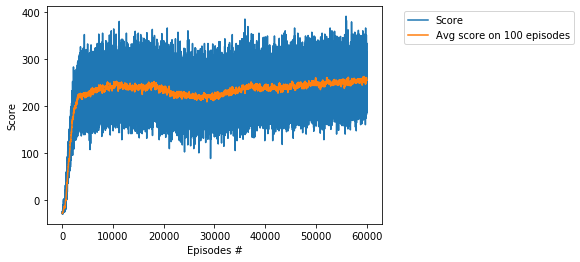

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg score on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

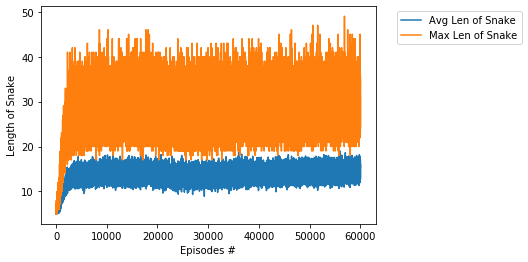

In [6]:
ax1 = fig.add_subplot(121)
plt.plot(np.arange(1, len(avg_len_of_snake)+1), avg_len_of_snake, label="Avg Len of Snake")
plt.plot(np.arange(1, len(max_len_of_snake)+1), max_len_of_snake, label="Max Len of Snake")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Length of Snake')
plt.xlabel('Episodes #')
plt.show()

mu:  27.39 , sigma:  4.61 , median:  27.0


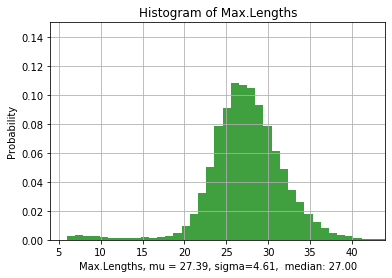

In [30]:
n, bins, patches = plt.hist(max_len_of_snake, 45, density=1, facecolor='green', alpha=0.75)
l = plt.plot(np.arange(1, len(bins) + 1), 'r--', linewidth=1)
mu = round(np.mean(max_len_of_snake), 2)
sigma = round(np.std(max_len_of_snake), 2)
median = round(np.median(max_len_of_snake), 2)
print('mu: ', mu, ', sigma: ', sigma, ', median: ', median)
plt.xlabel('Max.Lengths, mu = {:.2f}, sigma={:.2f},  median: {:.2f}'.format(mu, sigma, median))
plt.ylabel('Probability')
plt.title('Histogram of Max.Lengths')
plt.axis([4, 44, 0, 0.15])
plt.grid(True)

plt.show()